### 导入相应模块

In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import time
import tensorflow as tf
import tensorflow.contrib.slim as slim
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.set_random_seed(19)
from glob import glob
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import copy


In [21]:
print(scipy.__version__)
print(tf.__version__)

1.1.0
1.14.0


### 基础模块

In [2]:
def batch_norm(x, name="batch_norm"):
    return tf.contrib.layers.batch_norm(x, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, scope=name)

def instance_norm(input, name="instance_norm"):
    with tf.variable_scope(name):
        depth = input.get_shape()[3]
        scale = tf.get_variable("scale", [depth], initializer=tf.random_normal_initializer(1.0, 0.02, dtype=tf.float32))
        offset = tf.get_variable("offset", [depth], initializer=tf.constant_initializer(0.0))
        mean, variance = tf.nn.moments(input, axes=[1,2], keep_dims=True)
        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (input-mean)*inv
        return scale*normalized + offset

def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name="conv2d"):
    with tf.variable_scope(name):
        return slim.conv2d(input_, output_dim, ks, s, padding=padding, activation_fn=None,
                            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
        return slim.conv2d_transpose(input_, output_dim, ks, s, padding='SAME', activation_fn=None,
                                    weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                    biases_initializer=None)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [input_.get_shape()[-1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

### 可视化训练数据集

读取图像

In [3]:
def imread(path, is_grayscale = False):
    if (is_grayscale):
        return scipy.misc.imread(path, flatten = True).astype(np.float)
    else:
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

加载训练数据

In [4]:
def load_train_data(image_path, load_size=286, fine_size=256, is_testing=False):
    img_A = imread(image_path[0])
    img_B = imread(image_path[1])
    if not is_testing:
        img_A = scipy.misc.imresize(img_A, [load_size, load_size])
        img_B = scipy.misc.imresize(img_B, [load_size, load_size])
        h1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
        w1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
        img_A = img_A[h1:h1+fine_size, w1:w1+fine_size]
        img_B = img_B[h1:h1+fine_size, w1:w1+fine_size]

        if np.random.random() > 0.5:
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)
    else:
        img_A = scipy.misc.imresize(img_A, [fine_size, fine_size])
        img_B = scipy.misc.imresize(img_B, [fine_size, fine_size])

    img_A = img_A/127.5 - 1.
    img_B = img_B/127.5 - 1.

    img_AB = np.concatenate((img_A, img_B), axis=2)
    # img_AB shape: (fine_size, fine_size, input_c_dim + output_c_dim)
    return img_AB

加载测试数据

In [5]:
def load_test_data(image_path, fine_size=256):
    img = imread(image_path)
    img = scipy.misc.imresize(img, [fine_size, fine_size])
    img = img/127.5 - 1
    return img

In [6]:
class ImagePool(object):
    def __init__(self, maxsize=50):
        self.maxsize = maxsize
        self.num_img = 0
        self.images = []

    def __call__(self, image):
        if self.maxsize <= 0:
            return image
        if self.num_img < self.maxsize:
            self.images.append(image)
            self.num_img += 1
            return image
        if np.random.rand() > 0.5:
            idx = int(np.random.rand()*self.maxsize)
            tmp1 = copy.copy(self.images[idx])[0]
            self.images[idx][0] = image[0]
            idx = int(np.random.rand()*self.maxsize)
            tmp2 = copy.copy(self.images[idx])[1]
            self.images[idx][1] = image[1]
            return [tmp1, tmp2]
        else:
            return image

加载数据集

In [7]:
dataA = glob('./datasets/{}/*.*'.format('flower_images/trainA'))
dataB = glob('./datasets/{}/*.*'.format('flower_images/trainB'))

batch_files = list(zip(dataA[0:1], dataB[0:1]))
batch_images = [load_train_data(batch_file, 286, 256) for batch_file in batch_files]
batch_images = np.array(batch_images).astype(np.float32)

C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-pa

可视化

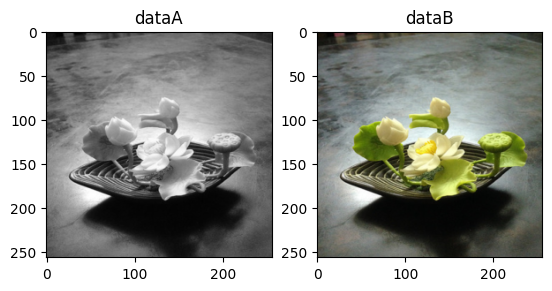

In [8]:
plt.subplot(121)
plt.title('dataA')
plt.imshow(batch_images[0][..., :3] * 0.5 + 0.5)

plt.subplot(122)
plt.title('dataB')
plt.imshow(batch_images[0][..., 3:] * 0.5 + 0.5)

保存图像

In [9]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image

    return img

def inverse_transform(images):
    return (images+1.)/2.

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

### 构建生成器

resnet生成器

In [10]:
# resnet生成器
def generator_resnet(image, options, reuse=False, name="generator"):
    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False

        def residule_block(x, dim, ks=3, s=1, name='res'):
            p = int((ks - 1) / 2)
            y = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")
            y = instance_norm(conv2d(y, dim, ks, s, padding='VALID', name=name+'_c1'), name+'_bn1')
            y = tf.pad(tf.nn.relu(y), [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")
            y = instance_norm(conv2d(y, dim, ks, s, padding='VALID', name=name+'_c2'), name+'_bn2')
            return y + x

        # Justin Johnson's model from https://github.com/jcjohnson/fast-neural-style/
        # The network with 9 blocks consists of: c7s1-32, d64, d128, R128, R128, R128,
        # R128, R128, R128, R128, R128, R128, u64, u32, c7s1-3
        c0 = tf.pad(image, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        c1 = tf.nn.relu(instance_norm(conv2d(c0, options.gf_dim, 7, 1, padding='VALID', name='g_e1_c'), 'g_e1_bn'))
        c2 = tf.nn.relu(instance_norm(conv2d(c1, options.gf_dim*2, 3, 2, name='g_e2_c'), 'g_e2_bn'))
        c3 = tf.nn.relu(instance_norm(conv2d(c2, options.gf_dim*4, 3, 2, name='g_e3_c'), 'g_e3_bn'))
        # define G network with 9 resnet blocks
        r1 = residule_block(c3, options.gf_dim*4, name='g_r1')
        r2 = residule_block(r1, options.gf_dim*4, name='g_r2')
        r3 = residule_block(r2, options.gf_dim*4, name='g_r3')
        r4 = residule_block(r3, options.gf_dim*4, name='g_r4')
        r5 = residule_block(r4, options.gf_dim*4, name='g_r5')
        r6 = residule_block(r5, options.gf_dim*4, name='g_r6')
        r7 = residule_block(r6, options.gf_dim*4, name='g_r7')
        r8 = residule_block(r7, options.gf_dim*4, name='g_r8')
        r9 = residule_block(r8, options.gf_dim*4, name='g_r9')

        d1 = deconv2d(r9, options.gf_dim*2, 3, 2, name='g_d1_dc')
        d1 = tf.nn.relu(instance_norm(d1, 'g_d1_bn'))
        d2 = deconv2d(d1, options.gf_dim, 3, 2, name='g_d2_dc')
        d2 = tf.nn.relu(instance_norm(d2, 'g_d2_bn'))
        d2 = tf.pad(d2, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        pred = tf.nn.tanh(conv2d(d2, options.output_c_dim, 7, 1, padding='VALID', name='g_pred_c'))

        return pred

unet生成器

In [11]:
# unet生成器
def generator_unet(image, options, reuse=False, name="generator"):

    dropout_rate = 0.5 if options.is_training else 1.0
    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False

        # image is (256 x 256 x input_c_dim)
        e1 = instance_norm(conv2d(image, options.gf_dim, name='g_e1_conv'))
        # e1 is (128 x 128 x self.gf_dim)
        e2 = instance_norm(conv2d(lrelu(e1), options.gf_dim*2, name='g_e2_conv'), 'g_bn_e2')
        # e2 is (64 x 64 x self.gf_dim*2)
        e3 = instance_norm(conv2d(lrelu(e2), options.gf_dim*4, name='g_e3_conv'), 'g_bn_e3')
        # e3 is (32 x 32 x self.gf_dim*4)
        e4 = instance_norm(conv2d(lrelu(e3), options.gf_dim*8, name='g_e4_conv'), 'g_bn_e4')
        # e4 is (16 x 16 x self.gf_dim*8)
        e5 = instance_norm(conv2d(lrelu(e4), options.gf_dim*8, name='g_e5_conv'), 'g_bn_e5')
        # e5 is (8 x 8 x self.gf_dim*8)
        e6 = instance_norm(conv2d(lrelu(e5), options.gf_dim*8, name='g_e6_conv'), 'g_bn_e6')
        # e6 is (4 x 4 x self.gf_dim*8)
        e7 = instance_norm(conv2d(lrelu(e6), options.gf_dim*8, name='g_e7_conv'), 'g_bn_e7')
        # e7 is (2 x 2 x self.gf_dim*8)
        e8 = instance_norm(conv2d(lrelu(e7), options.gf_dim*8, name='g_e8_conv'), 'g_bn_e8')
        # e8 is (1 x 1 x self.gf_dim*8)

        d1 = deconv2d(tf.nn.relu(e8), options.gf_dim*8, name='g_d1')
        d1 = tf.nn.dropout(d1, dropout_rate)
        d1 = tf.concat([instance_norm(d1, 'g_bn_d1'), e7], 3)
        # d1 is (2 x 2 x self.gf_dim*8*2)

        d2 = deconv2d(tf.nn.relu(d1), options.gf_dim*8, name='g_d2')
        d2 = tf.nn.dropout(d2, dropout_rate)
        d2 = tf.concat([instance_norm(d2, 'g_bn_d2'), e6], 3)
        # d2 is (4 x 4 x self.gf_dim*8*2)

        d3 = deconv2d(tf.nn.relu(d2), options.gf_dim*8, name='g_d3')
        d3 = tf.nn.dropout(d3, dropout_rate)
        d3 = tf.concat([instance_norm(d3, 'g_bn_d3'), e5], 3)
        # d3 is (8 x 8 x self.gf_dim*8*2)

        d4 = deconv2d(tf.nn.relu(d3), options.gf_dim*8, name='g_d4')
        d4 = tf.concat([instance_norm(d4, 'g_bn_d4'), e4], 3)
        # d4 is (16 x 16 x self.gf_dim*8*2)

        d5 = deconv2d(tf.nn.relu(d4), options.gf_dim*4, name='g_d5')
        d5 = tf.concat([instance_norm(d5, 'g_bn_d5'), e3], 3)
        # d5 is (32 x 32 x self.gf_dim*4*2)

        d6 = deconv2d(tf.nn.relu(d5), options.gf_dim*2, name='g_d6')
        d6 = tf.concat([instance_norm(d6, 'g_bn_d6'), e2], 3)
        # d6 is (64 x 64 x self.gf_dim*2*2)

        d7 = deconv2d(tf.nn.relu(d6), options.gf_dim, name='g_d7')
        d7 = tf.concat([instance_norm(d7, 'g_bn_d7'), e1], 3)
        # d7 is (128 x 128 x self.gf_dim*1*2)

        d8 = deconv2d(tf.nn.relu(d7), options.output_c_dim, name='g_d8')
        # d8 is (256 x 256 x output_c_dim)

        return tf.nn.tanh(d8)

### 构建判别器

In [12]:
# 判别器
def discriminator(image, options, reuse=False, name="discriminator"):
    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False
        h0 = lrelu(conv2d(image, options.df_dim, name='d_h0_conv'))
        # h0 is (128 x 128 x self.df_dim)
        h1 = lrelu(instance_norm(conv2d(h0, options.df_dim*2, name='d_h1_conv'), 'd_bn1'))
        # h1 is (64 x 64 x self.df_dim*2)
        h2 = lrelu(instance_norm(conv2d(h1, options.df_dim*4, name='d_h2_conv'), 'd_bn2'))
        # h2 is (32x 32 x self.df_dim*4)
        h3 = lrelu(instance_norm(conv2d(h2, options.df_dim*8, s=1, name='d_h3_conv'), 'd_bn3'))
        # h3 is (32 x 32 x self.df_dim*8)
        h4 = conv2d(h3, 1, s=1, name='d_h3_pred')
        # h4 is (32 x 32 x 1)
        return h4

### 定义损失函数

In [13]:
def abs_criterion(in_, target):
    return tf.reduce_mean(tf.abs(in_ - target))

def mae_criterion(in_, target):
    return tf.reduce_mean((in_-target)**2)

def sce_criterion(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

### 构建CycleGAN模型

In [14]:
class cyclegan(object):
    def __init__(self, sess, batch_size=1, fine_size=256, input_nc=3, output_nc=3, L1_lambda=10.0, dataset_dir='micky',
                 use_resnet=True, use_lsgan=True, ngf=64, ndf=64, phase='train', max_size=50):
        self.sess = sess
        self.batch_size = batch_size
        self.image_size = fine_size
        self.input_c_dim = input_nc
        self.output_c_dim = output_nc
        self.L1_lambda = L1_lambda
        self.dataset_dir = dataset_dir

        self.discriminator = discriminator
        if use_resnet:
            self.generator = generator_resnet
        else:
            self.generator = generator_unet
        if use_lsgan:
            self.criterionGAN = mae_criterion
        else:
            self.criterionGAN = sce_criterion

        OPTIONS = namedtuple('OPTIONS', 'batch_size image_size \
                              gf_dim df_dim output_c_dim is_training')
        self.options = OPTIONS._make((batch_size, fine_size, ngf, ndf,
                                      output_nc, phase == 'train'))

        self._build_model()
        self.saver = tf.train.Saver()
        self.pool = ImagePool(max_size)

    # 构建网络结构
    def _build_model(self):
        self.real_data = tf.placeholder(tf.float32,
                                        [None, self.image_size, self.image_size,
                                         self.input_c_dim + self.output_c_dim],
                                        name='real_A_and_B_images')

        self.real_A = self.real_data[:, :, :, :self.input_c_dim]
        self.real_B = self.real_data[:, :, :, self.input_c_dim:self.input_c_dim + self.output_c_dim]

        self.fake_B = self.generator(self.real_A, self.options, False, name="generatorA2B")
        self.fake_A_ = self.generator(self.fake_B, self.options, False, name="generatorB2A")
        self.fake_A = self.generator(self.real_B, self.options, True, name="generatorB2A")
        self.fake_B_ = self.generator(self.fake_A, self.options, True, name="generatorA2B")

        self.DB_fake = self.discriminator(self.fake_B, self.options, reuse=False, name="discriminatorB")
        self.DA_fake = self.discriminator(self.fake_A, self.options, reuse=False, name="discriminatorA")
        self.g_loss_a2b = self.criterionGAN(self.DB_fake, tf.ones_like(self.DB_fake)) \
            + self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) \
            + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)
        self.g_loss_b2a = self.criterionGAN(self.DA_fake, tf.ones_like(self.DA_fake)) \
            + self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) \
            + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)
        self.g_loss = self.criterionGAN(self.DA_fake, tf.ones_like(self.DA_fake)) \
            + self.criterionGAN(self.DB_fake, tf.ones_like(self.DB_fake)) \
            + self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) \
            + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)

        self.fake_A_sample = tf.placeholder(tf.float32,
                                            [None, self.image_size, self.image_size,
                                             self.input_c_dim], name='fake_A_sample')
        self.fake_B_sample = tf.placeholder(tf.float32,
                                            [None, self.image_size, self.image_size,
                                             self.output_c_dim], name='fake_B_sample')
        self.DB_real = self.discriminator(self.real_B, self.options, reuse=True, name="discriminatorB")
        self.DA_real = self.discriminator(self.real_A, self.options, reuse=True, name="discriminatorA")
        self.DB_fake_sample = self.discriminator(self.fake_B_sample, self.options, reuse=True, name="discriminatorB")
        self.DA_fake_sample = self.discriminator(self.fake_A_sample, self.options, reuse=True, name="discriminatorA")

        self.db_loss_real = self.criterionGAN(self.DB_real, tf.ones_like(self.DB_real))
        self.db_loss_fake = self.criterionGAN(self.DB_fake_sample, tf.zeros_like(self.DB_fake_sample))
        self.db_loss = (self.db_loss_real + self.db_loss_fake) / 2
        
        alpha = tf.random_uniform(
        shape=[self.batch_size,self.image_size, self.image_size,self.input_c_dim], 
        minval=0.,
        maxval=1.
        )
        differences = self.fake_B - self.real_B
        interpolates = self.real_B + (alpha*differences)
        gradients = tf.gradients(self.discriminator(interpolates, self.options, reuse=True, name="discriminatorB"), [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1.)**2)#### gredient penalty
        self.db_loss += 10*gradient_penalty
        
        self.da_loss_real = self.criterionGAN(self.DA_real, tf.ones_like(self.DA_real))
        self.da_loss_fake = self.criterionGAN(self.DA_fake_sample, tf.zeros_like(self.DA_fake_sample))
        self.da_loss = (self.da_loss_real + self.da_loss_fake) / 2
        
        #'''
        differences2 = self.fake_A - self.real_A
        interpolates2 = self.real_A + (alpha*differences2)
        gradients2 = tf.gradients(self.discriminator(interpolates2, self.options , reuse=True, name="discriminatorA"), [interpolates2])[0]
        slopes2 = tf.sqrt(tf.reduce_sum(tf.square(gradients2), reduction_indices=[1]))
        gradient_penalty2 = tf.reduce_mean((slopes2-1.)**2)
        self.da_loss += 10*gradient_penalty2
        #'''
        self.d_loss = self.da_loss + self.db_loss

        self.g_loss_a2b_sum = tf.summary.scalar("g_loss_a2b", self.g_loss_a2b)
        self.g_loss_b2a_sum = tf.summary.scalar("g_loss_b2a", self.g_loss_b2a)
        self.g_loss_sum = tf.summary.scalar("g_loss", self.g_loss)
        self.g_sum = tf.summary.merge([self.g_loss_a2b_sum, self.g_loss_b2a_sum, self.g_loss_sum])
        self.db_loss_sum = tf.summary.scalar("db_loss", self.db_loss)
        self.da_loss_sum = tf.summary.scalar("da_loss", self.da_loss)
        self.d_loss_sum = tf.summary.scalar("d_loss", self.d_loss)
        self.db_loss_real_sum = tf.summary.scalar("db_loss_real", self.db_loss_real)
        self.db_loss_fake_sum = tf.summary.scalar("db_loss_fake", self.db_loss_fake)
        self.da_loss_real_sum = tf.summary.scalar("da_loss_real", self.da_loss_real)
        self.da_loss_fake_sum = tf.summary.scalar("da_loss_fake", self.da_loss_fake)
        self.d_sum = tf.summary.merge(
            [self.da_loss_sum, self.da_loss_real_sum, self.da_loss_fake_sum,
             self.db_loss_sum, self.db_loss_real_sum, self.db_loss_fake_sum,
             self.d_loss_sum]
        )

        self.test_A = tf.placeholder(tf.float32,
                                     [None, self.image_size, self.image_size,
                                      self.input_c_dim], name='test_A')
        self.test_B = tf.placeholder(tf.float32,
                                     [None, self.image_size, self.image_size,
                                      self.output_c_dim], name='test_B')
        self.testB = self.generator(self.test_A, self.options, True, name="generatorA2B")
        self.testA = self.generator(self.test_B, self.options, True, name="generatorB2A")

        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]
        # for var in t_vars: print(var.name)


    def train(self, nepoch=200, epoch_step=100, train_size=100000000.0, load_size=286, lr=0.0001, beta1=0.5, print_freq=100,
              save_freq=1000, continue_train=False, checkpoint_dir='./checkpoint', sample_dir='./sample'):
        """Train cyclegan"""
        self.lr = tf.placeholder(tf.float32, None, name='learning_rate')
        #here we apply a different Adam optimizer with another beta2 bse
        self.d_optim = tf.train.AdamOptimizer(self.lr, beta1=beta1,beta2=0.9) \
            .minimize(self.d_loss, var_list=self.d_vars)
        self.g_optim = tf.train.AdamOptimizer(self.lr, beta1=beta1,beta2=0.9) \
            .minimize(self.g_loss, var_list=self.g_vars)

        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        self.writer = tf.summary.FileWriter("./logs", self.sess.graph)

        counter = 1
        start_time = time.time()

        if continue_train:
            if self.load(checkpoint_dir):
                print(" [*] Load SUCCESS")
            else:
                print(" [!] Load failed...")

        for epoch in range(nepoch):
            dataA = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/trainA'))
            dataB = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/trainB'))
            np.random.shuffle(dataA)
            np.random.shuffle(dataB)
            batch_idxs = min(min(len(dataA), len(dataB)), train_size) // self.batch_size
            lr = lr if epoch < epoch_step else lr*(nepoch-epoch)/(nepoch-epoch_step)

            for idx in range(0, batch_idxs):
                batch_files = list(zip(dataA[idx * self.batch_size:(idx + 1) * self.batch_size],
                                       dataB[idx * self.batch_size:(idx + 1) * self.batch_size]))
                batch_images = [load_train_data(batch_file, load_size,self.image_size) for batch_file in batch_files]
                batch_images = np.array(batch_images).astype(np.float32)

                # Update G network and record fake outputs
                fake_A, fake_B, _, summary_str = self.sess.run(
                    [self.fake_A, self.fake_B, self.g_optim, self.g_sum],
                    feed_dict={self.real_data: batch_images, self.lr: lr})
                self.writer.add_summary(summary_str, counter)
                [fake_A, fake_B] = self.pool([fake_A, fake_B])

                # Update D network
                _, summary_str = self.sess.run(
                    [self.d_optim, self.d_sum],
                    feed_dict={self.real_data: batch_images,
                               self.fake_A_sample: fake_A,
                               self.fake_B_sample: fake_B,
                               self.lr: lr})
                self.writer.add_summary(summary_str, counter)

                counter += 1
                print(("Epoch: [%2d] [%4d/%4d] time: %4.4f" % (
                    epoch, idx, batch_idxs, time.time() - start_time)))

                if np.mod(counter, print_freq) == 1:
                    self.sample_model(sample_dir, epoch, idx)

                if np.mod(counter, save_freq) == 2:
                    self.save(checkpoint_dir, counter)

    def save(self, checkpoint_dir, step):
        model_name = "cyclegan.model"
        model_dir = "%s_%s" % (self.dataset_dir, self.image_size)
        checkpoint_dir = os.path.join(checkpoint_dir, model_dir)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,
                        os.path.join(checkpoint_dir, model_name),
                        global_step=step)

    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoint...")

        model_dir = "%s_%s" % (self.dataset_dir, self.image_size)
        checkpoint_dir = os.path.join(checkpoint_dir) #, model_dir
        print(checkpoint_dir)
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        print(ckpt)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            return True
        else:
            return True

    def sample_model(self, sample_dir, epoch, idx):
        dataA = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testA'))
        dataB = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testB'))
        np.random.shuffle(dataA)
        np.random.shuffle(dataB)
        batch_files = list(zip(dataA[:self.batch_size], dataB[:self.batch_size]))
        sample_images = [load_train_data(batch_file, is_testing=True) for batch_file in batch_files]
        sample_images = np.array(sample_images).astype(np.float32)

        fake_A, fake_B = self.sess.run(
            [self.fake_A, self.fake_B],
            feed_dict={self.real_data: sample_images}
        )
        save_images(fake_A, [self.batch_size, 1],
                    './{}/A_{:02d}_{:04d}.jpg'.format(sample_dir, epoch, idx))
        save_images(fake_B, [self.batch_size, 1],
                    './{}/B_{:02d}_{:04d}.jpg'.format(sample_dir, epoch, idx))

    def test(self, which_direction='AtoB', checkpoint_dir='./checkpoint', test_dir='./test'):
        """Test cyclegan"""
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        if which_direction == 'AtoB':
            sample_files = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testA'))
            #print self.dataset_dir
        elif which_direction == 'BtoA':
            sample_files = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testB'))
        else:
            raise Exception('--which_direction must be AtoB or BtoA')
        #print args.checkpoint_dir
        if self.load(checkpoint_dir):
            print(" [*] Load SUCCESS")
        else:
            print(" [!] Load failed...")

        # write html for visual comparison
        index_path = os.path.join(test_dir, '{0}_index.html'.format(which_direction))
        index = open(index_path, "w")
        index.write("<html><body><table><tr>")
        index.write("<th>name</th><th>input</th><th>output</th></tr>")

        out_var, in_var = (self.testB, self.test_A) if which_direction == 'AtoB' else (
            self.testA, self.test_B)
        print(sample_files)
        for sample_file in sample_files:
            print('Processing image: ' + sample_file)
            sample_image = [load_test_data(sample_file, self.image_size)]
            sample_image = np.array(sample_image).astype(np.float32)
            image_path = os.path.join(test_dir,
                                      '{0}_{1}'.format(which_direction, os.path.basename(sample_file)))
            fake_img = self.sess.run(out_var, feed_dict={in_var: sample_image})
            save_images(fake_img, [1, 1], image_path)
            index.write("<td>%s</td>" % os.path.basename(image_path))
            index.write("<td><img src='%s'></td>" % (sample_file if os.path.isabs(sample_file) else (
                '..' + os.path.sep + sample_file)))
            index.write("<td><img src='%s'></td>" % (image_path if os.path.isabs(image_path) else (
                '..' + os.path.sep + image_path)))
            index.write("</tr>")
        index.close()

In [15]:
checkpoint_dir = "checkpoint/flower_images_256"
dataset_dir="flower_images"

### 训练CycleGAN

In [ ]:
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
with tf.Session(config=tfconfig) as sess:
    model = cyclegan(sess, dataset_dir=dataset_dir, phase="train")
    model.train()

### 推理 输入图片，将输出结果保存至./test

In [16]:
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
with tf.Session(config=tfconfig) as sess:
    model = cyclegan(sess, dataset_dir=dataset_dir, phase="test")
    model.test(checkpoint_dir=checkpoint_dir)

 [*] Reading checkpoint...
checkpoint/flower_images_256
model_checkpoint_path: "checkpoint/flower_images_256\\cyclegan.model-90002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-86002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-87002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-88002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-89002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-90002"

 [*] Load SUCCESS
['./datasets/flower_images/testA\\01.png', './datasets/flower_images/testA\\02.png', './datasets/flower_images/testA\\03.png', './datasets/flower_images/testA\\04.png', './datasets/flower_images/testA\\05.png', './datasets/flower_images/testA\\06.png', './datasets/flower_images/testA\\07.png', './datasets/flower_images/testA\\08.png', './datasets/flower_images/testA\\09.png', './datasets/flower_images/testA\\10.png', './datasets/flower_imag

C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we 

Processing image: ./datasets/flower_images/testA\02.png
Processing image: ./datasets/flower_images/testA\03.png
Processing image: ./datasets/flower_images/testA\04.png
Processing image: ./datasets/flower_images/testA\05.png
Processing image: ./datasets/flower_images/testA\06.png
Processing image: ./datasets/flower_images/testA\07.png
Processing image: ./datasets/flower_images/testA\08.png
Processing image: ./datasets/flower_images/testA\09.png
Processing image: ./datasets/flower_images/testA\10.png
Processing image: ./datasets/flower_images/testA\11.png
Processing image: ./datasets/flower_images/testA\12.png
Processing image: ./datasets/flower_images/testA\13.png
Processing image: ./datasets/flower_images/testA\14.png
Processing image: ./datasets/flower_images/testA\15.png
Processing image: ./datasets/flower_images/testA\16.png
Processing image: ./datasets/flower_images/testA\17.png
Processing image: ./datasets/flower_images/testA\18.png


### 可视化

C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-pa

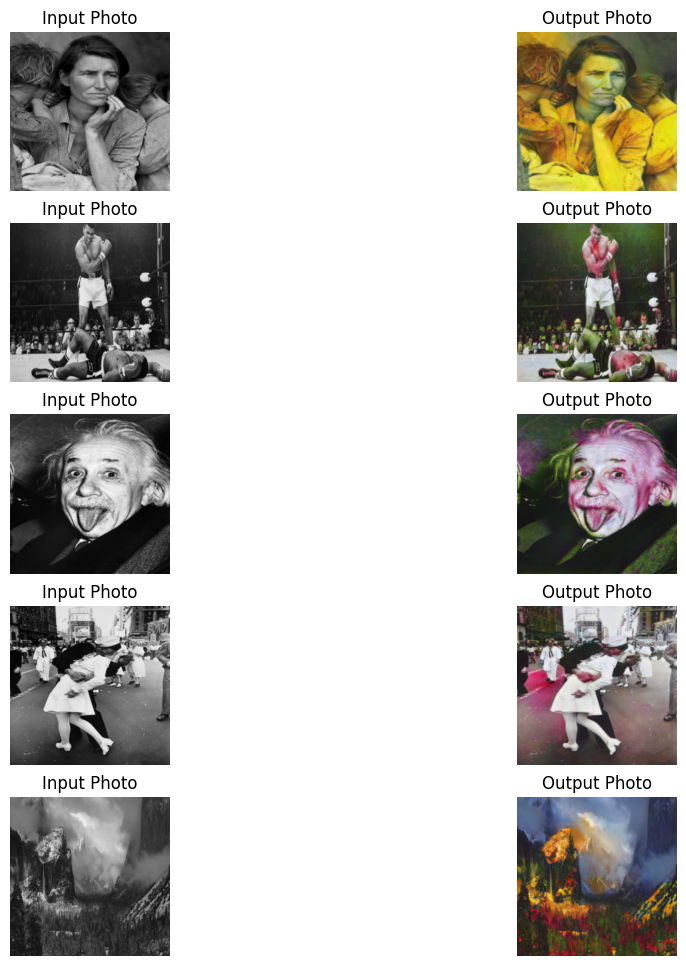

In [17]:
inputs = glob("datasets/{}/testA/*.png*".format(dataset_dir))
outputs = glob("test/*.png*")

batch_files = list(zip(inputs[0:5], outputs[0:5]))
batch_images = [load_train_data(batch_file, 286, 256) for batch_file in batch_files]
batch_images = np.array(batch_images).astype(np.float32)
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, imgs in enumerate(batch_images):
    ax[i, 0].imshow(imgs[..., :3] * 0.5 + 0.5)
    ax[i, 1].imshow(imgs[..., 3:] * 0.5 + 0.5)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Output Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")